## Structured APIs - DataFrames and SQL

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/24 00:46:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/24 00:46:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## dataPaths

In [3]:
flightDataJson2015 = '/tmp/data/flight-data/json/2015-summary.json'
flightDataJson = '/tmp/data/flight-data/json/*-summary.json'
retailData20101201 = '/tmp/data/retail-data/by-day/2010-12-01.csv'
retailDataAll = '/tmp/data/retail-data/all/*.csv'
flightDataCSV2010 = '/tmp/data/flight-data/csv/2010-summary.csv'
flightDataJson2010 = '/tmp/data/flight-data/json/2010-summary.json'
flightDataParquet2010 = '/tmp/data/flight-data/parquet/2010-summary.parquet'
flightDataORC2010 = '/tmp/data/flight-data/orc/2010-summary.orc'
sqliteJDBC = '/tmp/data/flight-data/jdbc/my-sqlite.db'

In [4]:
spark.conf.set("spark.sql.shuffle.partitions", 5)

## Structured API Overview

### How code is executed across the cluster:
1. write DF/DS/SQL
2. if valid code, Spark converts this to a **Logical Plan**
3. Spark transforms this **Logical Plan** to a **Physical Plan**, checking for optimizations along the way
4. Spark executes this **Physical Plan** (RDD manipulations) across the cluster

_Catalyst Optimizer analyzes and decides how the code should be executed via a plan_

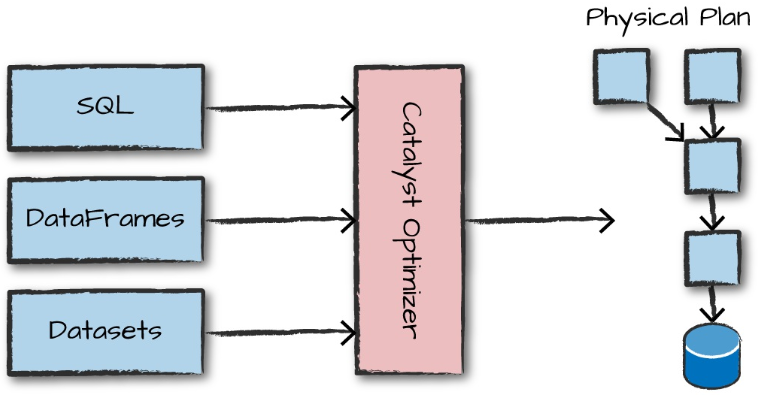

### Plan Execution:
1.  Convert user's code into an Unresolved Logical Plan
2.  Unresolved Logical Plan uses the Catalog to that check object (DF/DS/SQL) information is valid
3.  If valid, Catalyst Optimizer collects information that attempts to optimize the Logical Plan
4.  After Logical Plan is created, Spark plans out the Physical Plan
5.  Physical Plan maps process of how logic will be executed on the cluster

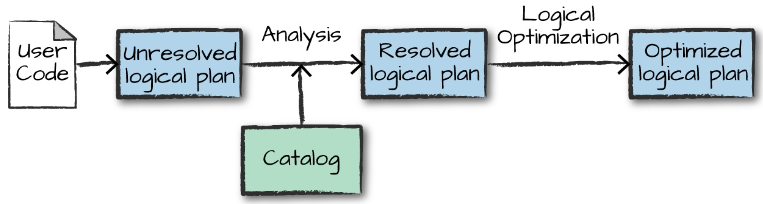

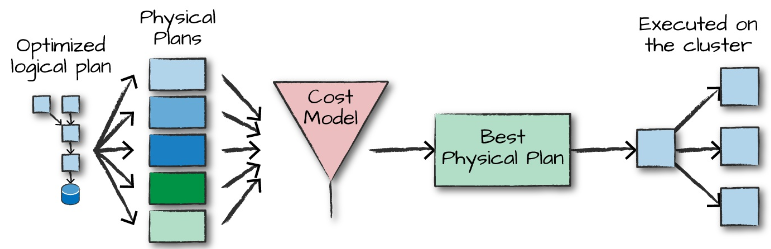

## Structured Operations

### Definitions:
-  **Schema** (defines the column names and types of a DF):
    - schema on read is fine for ad hoc use cases however inferring the schema can be expensive and or incorrect
    - it is recommended to define schema for production ETL use cases   
    <br>
-  **Structure**:
-   StructType(
        List(
            StructField(DEST_COUNTRY_NAME,StringType,true),
            StructField(ORIGIN_COUNTRY_NAME,StringType,true),
            StructField(count,LongType,true)
        )
    ) 
    - StructType [schema made up of a number of fields]
    - StructField [contain name, type, boolean flag specifying whether a column can contain missing or null values]
    - Metadata [way of storing information about this column]   
    <br>
-  **Expressions**:
    - expr("(((someCol + 5) * 200) - 6) < otherCol") 
<br>
-  **Columns**:
    - Columns in Spark are similar to columns in a spreadsheet, R dataframe, or pandas DataFrame.
    <br>
-  **Rows**:
    -  each row in a DF is a single record of type Row
    -  Row objects internally arrays of bytes   
    <br>
-  **Repartition**:
    -  repartition forces a full shuffle of the data
    -  typically only use repartition when the future # of partitions is > current # of partitions
    -  can be used when paritioning by a set of columns (ex: frequent filter on same column)   
    <br>
-  **Coalesce**:
    -  does not cause a shuffle instead tries to combine partitions

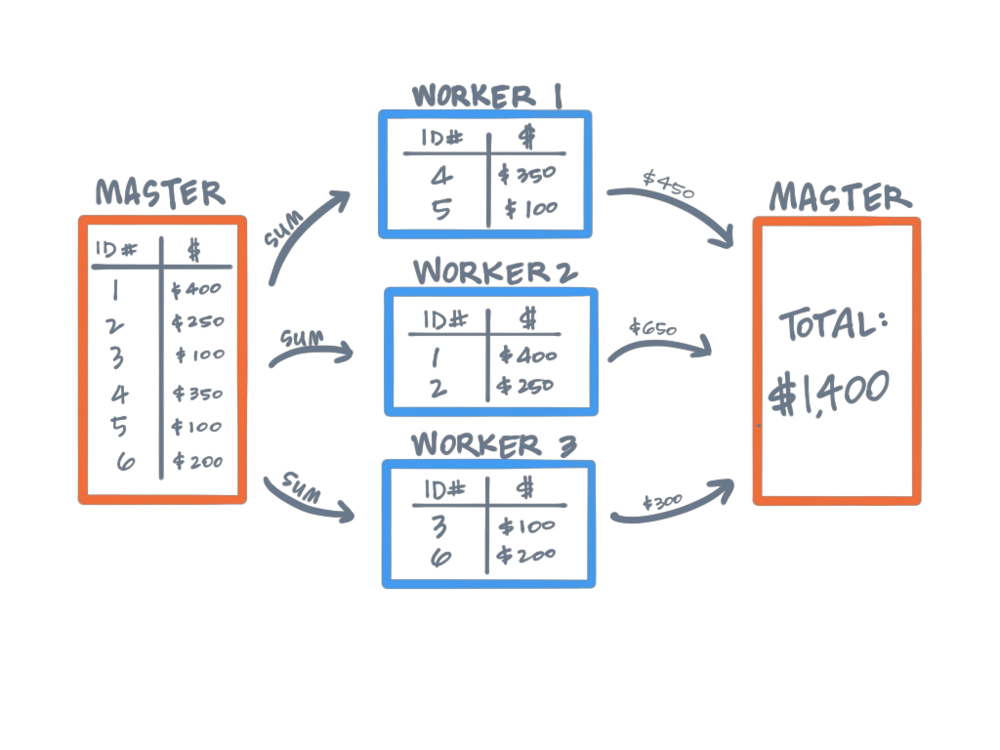

 - The repartition algorithm does a full shuffle of the data and creates equal sized partitions of data. 
 - coalesce combines existing partitions to avoid a full shuffle.

### Repartition vs Coalesce - When to use what ?

#### Repartition can be used under these scenarios,

 - when you want your output partitions to be of equally distributed chunks.
 - increase the number of partitions.
 - perform a shuffle of the data and create partitions.

#### Coalesce can be used under the following scenarios,

 - when you want to decrease the number of partitions.
 - in order to avoid shuffle when decreasing partitions.

In [5]:
sc = spark.sparkContext

In [6]:
x = sc.parallelize([1,2,3,4,5,6],3)

In [8]:
x .getNumPartitions()

3

In [9]:
y=x.repartition(2)

In [10]:
y.getNumPartitions()

2

### DataFrame Transformations:
-  add rows or columns
-  remove rows or columns
-  transform a row into a column
-  transform a column into a row
-  change order of rows based on the values in columns

## DataFrames

### _Schema Example_

In [11]:
flightDataJson2015

'/tmp/data/flight-data/json/2015-summary.json'

In [12]:
from pyspark.sql.types import StructField, StructType, StringType, LongType

In [18]:
myschema = StructType([\
                            StructField("DEST_COUNTRY_NAME", StringType(), nullable=False),\
                            StructField("ORIGIN_COUNTRY_NAME", StringType(), nullable=False),\
                            StructField("count", LongType(), nullable=False, metadata={"hello":"world"}),\
                            StructField("_corrupt_record", StringType(), nullable=False)\
                            ])

In [19]:
!ls /tmp/data/flight-data

csv  jdbc  json  orc  parquet


In [20]:
df2 = spark.read.format("json").schema(myschema).load(flightDataJson2015)
#df2 = spark.read.format("json").option("mode", "DROPMALFORMED").schema(myschema).load(flightDataJson2015)
#df2 = spark.read.format("json").option("mode", "FAILFAST").schema(myschema).load(flightDataJson2015)

In [21]:
df2.rdd.getNumPartitions()

1

In [23]:
df2.explain()

== Physical Plan ==
FileScan json [DEST_COUNTRY_NAME#0,ORIGIN_COUNTRY_NAME#1,count#2L,_corrupt_record#3] Batched: false, DataFilters: [], Format: JSON, Location: InMemoryFileIndex(1 paths)[file:/tmp/data/flight-data/json/2015-summary.json], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:bigint,_corrupt_record:string>




In [24]:
df3=df2.where("count > 100")

In [25]:
df2.where("count > 100").count()

119

In [26]:
df3.count()

119

In [27]:
df3.cache()

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint, _corrupt_record: string]

In [28]:
df3.unpersist()

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint, _corrupt_record: string]

In [29]:
df3.count()

119

### _Create Schema Example_

In [ ]:
from pyspark.sql.types import StructField, StructType, StringType, LongType

In [ ]:
myManualSchema = StructType([\
                            StructField("DEST_COUNTRY_NAME", StringType(), nullable=False),\
                            StructField("ORIGIN_COUNTRY_NAME", StringType(), nullable=False),\
                            StructField("count", StringType(), nullable=False, metadata={"hello":"world"})\
                            ])
df1 = spark.read.format("json").schema(myManualSchema)\
.load(flightDataJson2015)

In [ ]:
df1.printSchema()

### _Columns Example_

In [ ]:
from pyspark.sql.functions import col, column

In [ ]:
print(col("someColumnName"))
print(column("someColumnName"))

In [ ]:
spark.read.format("json").load(flightDataJson2015).columns

### _Expressions Example_

In [19]:
from pyspark.sql.functions import expr

In [20]:
# df code
(((col("someCol") + 5) * 200) - 6) < col("otherCol")

Column<'((((someCol + 5) * 200) - 6) < otherCol)'>

In [21]:
# sql code
expr("(((someCol + 5) * 200) - 6) < otherCol")

Column<'((((someCol + 5) * 200) - 6) < otherCol)'>

### _Row Example_

In [22]:
from pyspark.sql import Row

In [23]:
myRow = Row("Hello", None, 1, False)

In [24]:
# accessing row elements
print(myRow[0])
print(myRow[2])

Hello
1


### _Creating DF Example_

In [25]:
df = spark.read.format("json").load(flightDataJson2015)
df.createOrReplaceTempView("dfTable")

### _Convert Rows to DF Example_

In [26]:
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType

In [27]:
myManualSchema = StructType([\
                            StructField("some", StringType(), True),\
                            StructField("col", StringType(), True),\
                            StructField("names", LongType(), False)\
                            ])
myRow = Row("Hello", None, 1)
myDF = spark.createDataFrame([myRow], myManualSchema)
myDF.show()

+-----+----+-----+
| some| col|names|
+-----+----+-----+
|Hello|null|    1|
+-----+----+-----+



### _select & expr Example_

In [28]:
df.select("DEST_COUNTRY_NAME").show(3)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
|    United States|
+-----------------+
only showing top 3 rows



In [29]:
from pyspark.sql.functions import expr, col, column

In [30]:
df.select(\
         expr("DEST_COUNTRY_NAME as MyCol1"),\
         col("DEST_COUNTRY_NAME"),\
         column("DEST_COUNTRY_NAME"))\
.show(3)

+-------------+-----------------+-----------------+
|       MyCol1|DEST_COUNTRY_NAME|DEST_COUNTRY_NAME|
+-------------+-----------------+-----------------+
|United States|    United States|    United States|
|United States|    United States|    United States|
|United States|    United States|    United States|
+-------------+-----------------+-----------------+
only showing top 3 rows



In [31]:
df.select(expr("DEST_COUNTRY_NAME AS destination")).show(3)

+-------------+
|  destination|
+-------------+
|United States|
|United States|
|United States|
+-------------+
only showing top 3 rows



In [32]:
df.select(expr("DEST_COUNTRY_NAME AS destination").alias("DEST_COUNTRY_NAME")).show(3)

+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
|    United States|
|    United States|
|    United States|
+-----------------+
only showing top 3 rows



### _withColumnRenamed Example_

In [36]:
df.withColumnRenamed("DEST_COUNTRY_NAME", "dest").columns

['dest', 'ORIGIN_COUNTRY_NAME', 'count']

### _Removing Columns [drop] Example_

In [40]:
df.drop("ORIGIN_COUNTRY_NAME").columns

['DEST_COUNTRY_NAME', 'count']

### _Filter Rows [filter/where] Example_

In [43]:
df.filter(col("count") < 2).show(3)
df.where("count < 2").show(3)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 3 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Croatia|    1|
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
+-----------------+-------------------+-----+
only showing top 3 rows



In [44]:
# use WHERE for multiple "AND" filters since Spark performs all FILTER operations at the same time
df.where(col("count") < 2).where(col("ORIGIN_COUNTRY_NAME") != "Croatia").show(3)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|          Singapore|    1|
|          Moldova|      United States|    1|
|            Malta|      United States|    1|
+-----------------+-------------------+-----+
only showing top 3 rows



### _Unique Rows [distinct] Example_

In [45]:
df.select("ORIGIN_COUNTRY_NAME", "DEST_COUNTRY_NAME").distinct().count()

256

### _Sorting Rows [sort & orderBy] Example_

In [52]:
from pyspark.sql.functions import desc, asc

In [53]:
# default sort is ascending order
df.sort("count").show(3)
df.orderBy("count", "DEST_COUNTRY_NAME").show(3)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|      New Country|      Other Country|    0|
|            Malta|      United States|    1|
|    United States|          Singapore|    1|
+-----------------+-------------------+-----+
only showing top 3 rows

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|      New Country|      Other Country|    0|
|     Burkina Faso|      United States|    1|
|    Cote d'Ivoire|      United States|    1|
+-----------------+-------------------+-----+
only showing top 3 rows



In [54]:
df.orderBy(col("count").desc(), col("DEST_COUNTRY_NAME").asc()).show(5)

+-----------------+-------------------+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|    count|
+-----------------+-------------------+---------+
|    New Country 2|    Other Country 3|999999999|
|    United States|      United States|   370002|
|    United States|             Canada|     8483|
|           Canada|      United States|     8399|
|    United States|             Mexico|     7187|
+-----------------+-------------------+---------+
only showing top 5 rows



### _Limit [limit] Example_

In [55]:
df.limit(3).show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
+-----------------+-------------------+-----+



### _Repartitioning [repartition & coalesce] Example_

 - Repartition will incur a full shuffle of the data, regardless of whether one is necessary
 - This means that you should typically only repartition when the future number of partitions is greater than your current number of partitions or when you are looking to partition by a set of columns

In [56]:
df.rdd.getNumPartitions()

5

In [60]:
from pyspark.sql.functions import spark_partition_id

In [61]:
df.repartition(5).withColumn("partitionID", spark_partition_id()).show(2000)

+--------------------+--------------------+---------+-----------+
|   DEST_COUNTRY_NAME| ORIGIN_COUNTRY_NAME|    count|partitionID|
+--------------------+--------------------+---------+-----------+
|       United States|             Denmark|      152|          0|
|       United States|          Martinique|       43|          0|
|       United States|         Saint Lucia|      136|          0|
|             Ireland|       United States|      335|          0|
|         South Korea|       United States|     1048|          0|
|       United States|               Italy|      438|          0|
|       United States|              Greece|       23|          0|
|Bonaire, Sint Eus...|       United States|       58|          0|
|              France|       United States|      935|          0|
|       United States|              Cyprus|        1|          0|
|       United States|          Montenegro|        1|          0|
|       United States|             Austria|       63|          0|
|         

## Working with Different Types of Data

In [66]:
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load(retailData20101201)
df.printSchema()
df.createOrReplaceTempView("dfTable")

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [67]:
df.limit(3).show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+



### _Boolean Example_

In [68]:
from pyspark.sql.functions import col

In [69]:
df.where(col("InvoiceNo") != 536365)\
.select("InvoiceNo", "Description")\
.show(5, False)

+---------+-----------------------------+
|InvoiceNo|Description                  |
+---------+-----------------------------+
|536366   |HAND WARMER UNION JACK       |
|536366   |HAND WARMER RED POLKA DOT    |
|536367   |ASSORTED COLOUR BIRD ORNAMENT|
|536367   |POPPY'S PLAYHOUSE BEDROOM    |
|536367   |POPPY'S PLAYHOUSE KITCHEN    |
+---------+-----------------------------+
only showing top 5 rows



In [70]:
df.where("InvoiceNo = 536365").show(5, False)
df.where("InvoiceNo != 536365").show(5, False)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
+---------+-----

In [73]:
# manual import
from pyspark.sql.functions import count, mean, stddev_pop, min, max

### _Capitalize per Whitespace [initcap] Example_

In [74]:
from pyspark.sql.functions import initcap

In [75]:
df.select("Description", initcap(col("Description"))).show(3, False)

+----------------------------------+----------------------------------+
|Description                       |initcap(Description)              |
+----------------------------------+----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER|White Hanging Heart T-light Holder|
|WHITE METAL LANTERN               |White Metal Lantern               |
|CREAM CUPID HEARTS COAT HANGER    |Cream Cupid Hearts Coat Hanger    |
+----------------------------------+----------------------------------+
only showing top 3 rows



### _Uppercase & Lowercase [upper / lower] Example_

In [76]:
from pyspark.sql.functions import lower, upper

In [77]:
df.select(col("Description"),\
         lower(col("Description")),\
         upper(lower(col("Description")))).show(3, False)

+----------------------------------+----------------------------------+----------------------------------+
|Description                       |lower(Description)                |upper(lower(Description))         |
+----------------------------------+----------------------------------+----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER|white hanging heart t-light holder|WHITE HANGING HEART T-LIGHT HOLDER|
|WHITE METAL LANTERN               |white metal lantern               |WHITE METAL LANTERN               |
|CREAM CUPID HEARTS COAT HANGER    |cream cupid hearts coat hanger    |CREAM CUPID HEARTS COAT HANGER    |
+----------------------------------+----------------------------------+----------------------------------+
only showing top 3 rows



### _Removing Spaces [lpad, ltrim, rpad, rtrim, trim] Example_

In [78]:
from pyspark.sql.functions import lit, ltrim, rtrim, rpad, lpad, trim

In [79]:
df.select(\
         ltrim(lit("   HELLO   ")).alias("ltrim"),\
         rtrim(lit("   HELLO   ")).alias("rtrim"),\
         trim(lit("   HELLO   ")).alias("trim"),\
         lpad(lit("HELLO"), 3, " ").alias("lp"),\
         rpad(lit("HELLO"), 10, "x").alias("rp")).show(3)

+--------+--------+-----+---+----------+
|   ltrim|   rtrim| trim| lp|        rp|
+--------+--------+-----+---+----------+
|HELLO   |   HELLO|HELLO|HEL|HELLOxxxxx|
|HELLO   |   HELLO|HELLO|HEL|HELLOxxxxx|
|HELLO   |   HELLO|HELLO|HEL|HELLOxxxxx|
+--------+--------+-----+---+----------+
only showing top 3 rows



## User-Defined Functions
 - Make it possible for you to write your own custom transformations
 - UDFs can take and return one or more columns as input
 - They’re just functions that operate on the data, record by record
 - 

 - The first step is the actual function. We’ll create a simple one for this example
 - Let’s write a power3 function that takes a number and raises it to a power of three
 

### _UDF Example_

In [60]:
udfExampleDF = spark.range(5).toDF("num")
def power3(double_value):
  return double_value ** 3
power3(2.0)


8.0

In [61]:
udfExampleDF2 = spark.range(50).toDF("num2")
spark.ud

In [55]:
udfExampleDF.show()

+---+
|num|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [56]:
from pyspark.sql.functions import udf

 - Now that we’ve created these functions and tested them, we need to register them with Spark so that we can use them on all of our worker machines.
 

In [57]:
power3udf = udf(power3)

 - We can use that just like any other DataFrame function

In [58]:
from pyspark.sql.functions import col

In [62]:
udfExampleDF2.select(power3udf(col("num2"))).show(3)

+------------+
|power3(num2)|
+------------+
|           0|
|           1|
|           8|
+------------+
only showing top 3 rows



# Aggregations

In [91]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(retailDataAll)\
  .coalesce(5)
df.cache()
df.createOrReplaceTempView("dfTable")

In [92]:
from pyspark.sql.functions import count
df.select(count("StockCode")).show() # 541909

+----------------+
|count(StockCode)|
+----------------+
|          541909|
+----------------+



In [93]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("StockCode")).show() # 4070

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                     4070|
+-------------------------+



In [94]:
from pyspark.sql.functions import approx_count_distinct
df.select(approx_count_distinct("StockCode", 0.1)).show() # 3364

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                            3364|
+--------------------------------+



In [95]:
from pyspark.sql.functions import first, last
df.select(first("StockCode"), last("StockCode")).show()

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|          85123A|          22138|
+----------------+---------------+



In [96]:
from pyspark.sql.functions import min, max
df.select(min("Quantity"), max("Quantity")).show()

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|       -80995|        80995|
+-------------+-------------+



In [97]:
from pyspark.sql.functions import sum
df.select(sum("Quantity")).show() # 5176450

+-------------+
|sum(Quantity)|
+-------------+
|      5176450|
+-------------+



In [98]:
from pyspark.sql.functions import sumDistinct
df.select(sumDistinct("Quantity")).show() # 29310

C:\Spark\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\functions.py:214: FutureWarning: Deprecated in 3.2, use sum_distinct instead.
  warnings.warn("Deprecated in 3.2, use sum_distinct instead.", FutureWarning)


+----------------------+
|sum(DISTINCT Quantity)|
+----------------------+
|                 29310|
+----------------------+



## _Data Sources_

### _CSV Read Example_

In [106]:
from pyspark.sql.types import StructField, StructType, StringType, LongType

In [107]:
myManualSchema = StructType([\
    StructField("DEST_COUNTRY_NAME", StringType(), True),\
    StructField("ORIGIN_COUNTRY_NAME", StringType(), True),\
    StructField("count", LongType(), False)])

In [108]:
csvFile = spark.read.format("csv")\
.option("header", "true")\
.option("mode", "FAILFAST")\
.schema(myManualSchema)\
.load(flightDataCSV2010)

In [ ]:
csvFile.show(3)

### _CSV Write Example_

In [110]:
csvFile.write.format("csv").mode("overwrite").option("sep", "\t")\
.save("csvWrite.csv")

In [111]:
# reflects # of files outputed to target save directory
csvFile.rdd.getNumPartitions()

1

### _JSON Read Example_

In [113]:
spark.read.format("json").option("mode", "FAILFAST")\
.option("inferSchema", "true")\
.load(flightDataJson2010).show(3)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|    1|
|    United States|            Ireland|  264|
|    United States|              India|   69|
+-----------------+-------------------+-----+
only showing top 3 rows



### _JSON Write Example_

In [114]:
csvFile.write.format("json").mode("overwrite")\
.save("jsonWrite.json")

### _Parquet Read Example_

In [116]:
spark.read.format("parquet")\
.load(flightDataParquet2010).show(3)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|    1|
|    United States|            Ireland|  264|
|    United States|              India|   69|
+-----------------+-------------------+-----+
only showing top 3 rows



### _Parquet Write Example_

In [117]:
csvFile.write.format("parquet").mode("overwrite")\
.save("parquetWrite.parquet")

### _ORC Read Example_

In [ ]:
spark.read.format("orc")\
.load(flightDataORC2010).show(3)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|    1|
|    United States|            Ireland|  264|
|    United States|              India|   69|
+-----------------+-------------------+-----+
only showing top 3 rows

